__Stacking and Ensembling__

*Oscar Padilla*

# Introduction

The goal of this case study is to build a predictive model utilizing stacking and ensembling methods.

The dataset provided consists of 160 thousand records and 50 features plus the response variable (binary: 0 or 1). No metadata provided.

This is a binary classification problem (1 vs. 0).

Another piece of information provided is that the cost to the business of a false positive prediction is 1,000 USD while the cost of a false negative prediction is only 10 USD.

# Background

Basic concepts: Binary Classification, Confusion Matrix, Ensemble Learning

## Binary Classification

The classification methods utilized in this case study are listed in this section, as well as, the parameters applied on each.

### Logistic Regression

* `solver='lbfgs'` (FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning)
* `max_iter=1000` (for the classifier) and `max_iter=100` for *soft voting*

### K-Neighbors

* `n_neighbors=3`


### Support Vector Classification

* `gamma='auto'` 
* `probability = True` (necessary for *soft voting*)

Extremely slow because the computation of a distance function leads to:

$n_{features} \times n^{2}_{observations}$

In this particular case study, we are dealing with 50+ features (after one-hot-encoding) times 160k observations-square!

### Random Forest

* `n_estimators = 100`

### Neural Networks

* layers: 3
* neurons: 100
* activation = `relu`
* batch: 1000
* kernel: uniform
* optimizer: SGD

## Confusion Matrix

Because the cost to the business of false positives and false negatives is different, the confusion matrix was selected as the performance measure. Confusion Matrix basic terms:

* __true positives__ (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.

* __true negatives__ (TN): We predicted no, and they don't have the disease.

* __false positives__ (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

* __false negatives__ (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")


## Ensemble Learning

Ensemble methods is a machine learning technique that combines several base models in order to produce one optimal predictive model [2]. Ensemble methods are based on the *wisdom of the crowd* principle.

A particular type of ensemble learning is *Random Forests*, which trains multiple Decision Trees on different training data subsets.

There are 2 main types of voting classifiers:

### Hard Voting

A *hard voting* classifier aggregates the predictions of each classifier and predicts the class that gets the most votes. This voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a *weak learner*, the ensemble can still be a *strong learner* (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse. [1]

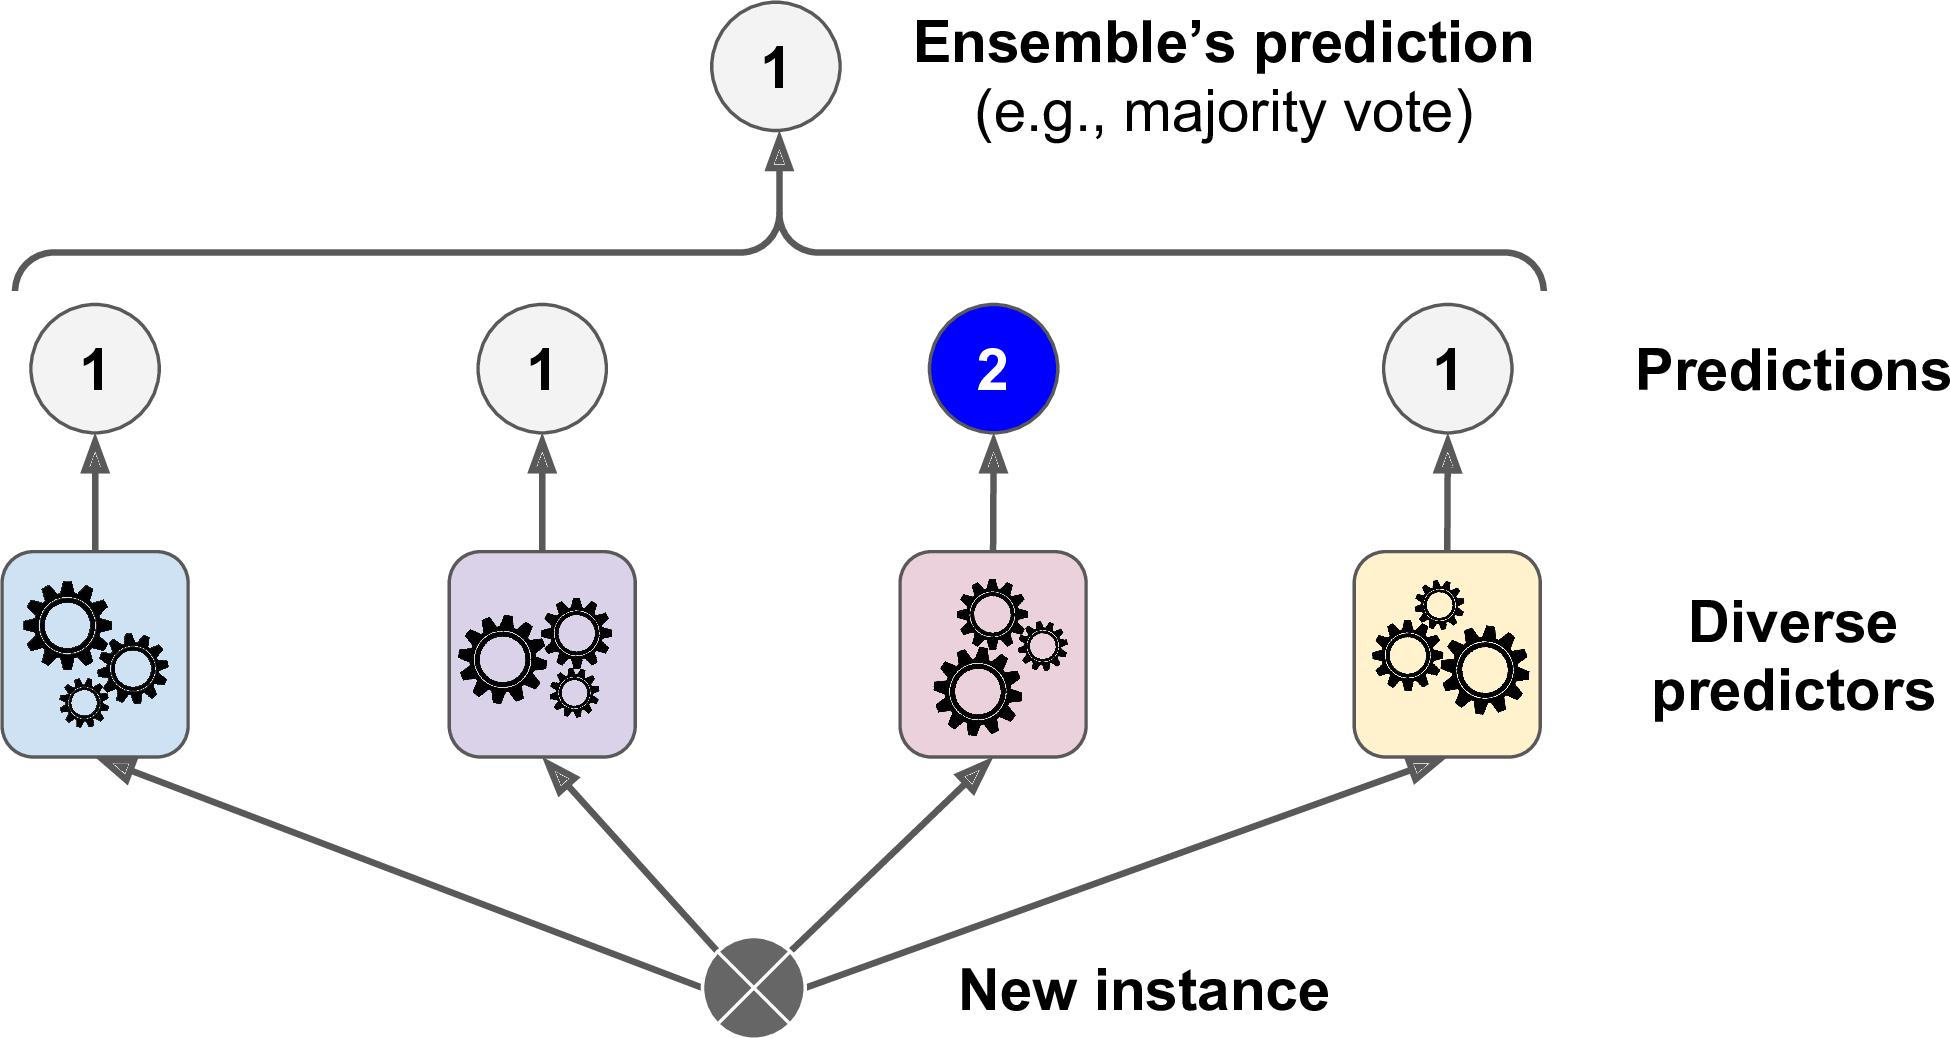

In [126]:
from IPython.display import Image
Image(filename='hard_voting_classifiers.png')

Figure 1. Hard Voting Classifier Predictions [1]

### Soft Voting

On the other hand, *soft voting* predicts the class with the highest class probability by taking the average over all the individual classifiers. It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

> Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy. [1]

# Methods

## Setup and Data Import

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('bmh')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import log_loss

/Users/oscarpadilla/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/oscarpadilla/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
import sys
import sklearn
print(sys.executable)
print(sys.version)
print(sys.version_info)
print('sklearn: %s' % sklearn.__version__)

/Users/oscarpadilla/anaconda3/envs/tensorflow/bin/python
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
sklearn: 0.19.1


## Exploratory Data Analysis

### Data Cleaning
Data types

In [7]:
data = pd.read_csv("final_project.csv")

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
x0     159974 non-null float64
x1     159975 non-null float64
x2     159962 non-null float64
x3     159963 non-null float64
x4     159974 non-null float64
x5     159963 non-null float64
x6     159974 non-null float64
x7     159973 non-null float64
x8     159979 non-null float64
x9     159970 non-null float64
x10    159957 non-null float64
x11    159970 non-null float64
x12    159964 non-null float64
x13    159969 non-null float64
x14    159966 non-null float64
x15    159965 non-null float64
x16    159974 non-null float64
x17    159973 non-null float64
x18    159960 non-null float64
x19    159965 non-null float64
x20    159962 non-null float64
x21    159971 non-null float64
x22    159973 non-null float64
x23    159953 non-null float64
x24    159972 non-null object
x25    159978 non-null float64
x26    159964 non-null float64
x27    159970 non-null float64
x28    159965 non-null

Missing data

In [9]:
data.isnull().sum()

x0     26
x1     25
x2     38
x3     37
x4     26
x5     37
x6     26
x7     27
x8     21
x9     30
x10    43
x11    30
x12    36
x13    31
x14    34
x15    35
x16    26
x17    27
x18    40
x19    35
x20    38
x21    29
x22    27
x23    47
x24    28
x25    22
x26    36
x27    30
x28    35
x29    30
x30    30
x31    39
x32    31
x33    41
x34    41
x35    30
x36    27
x37    23
x38    31
x39    23
x40    36
x41    40
x42    26
x43    37
x44    40
x45    29
x46    31
x47    37
x48    32
x49    32
y       0
dtype: int64

### Type Conversion

In [10]:
data['x32'].head()

0      0.0%
1    -0.02%
2    -0.01%
3     0.01%
4     0.01%
Name: x32, dtype: object

In [11]:
data['x32'] = data['x32'].str.rstrip('%').astype('float') / 100.0
data['x32'].head()

0    0.0000
1   -0.0002
2   -0.0001
3    0.0001
4    0.0001
Name: x32, dtype: float64

In [12]:
data['x37'].head()

0     $1313.96
1     $1962.78
2      $430.47
3    $-2366.29
4     $-620.66
Name: x37, dtype: object

In [13]:
data['x37'] = data['x37'].replace('[\$,]', '', regex=True).astype(float)
data['x37'].head()

0    1313.96
1    1962.78
2     430.47
3   -2366.29
4    -620.66
Name: x37, dtype: float64

Converting from `float64` to `float32` in order to save memory

In [14]:
data_float = data.select_dtypes(include = ['float64'])
data_float = data_float.astype(np.float32)
data_float.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 47 columns):
x0     159974 non-null float32
x1     159975 non-null float32
x2     159962 non-null float32
x3     159963 non-null float32
x4     159974 non-null float32
x5     159963 non-null float32
x6     159974 non-null float32
x7     159973 non-null float32
x8     159979 non-null float32
x9     159970 non-null float32
x10    159957 non-null float32
x11    159970 non-null float32
x12    159964 non-null float32
x13    159969 non-null float32
x14    159966 non-null float32
x15    159965 non-null float32
x16    159974 non-null float32
x17    159973 non-null float32
x18    159960 non-null float32
x19    159965 non-null float32
x20    159962 non-null float32
x21    159971 non-null float32
x22    159973 non-null float32
x23    159953 non-null float32
x25    159978 non-null float32
x26    159964 non-null float32
x27    159970 non-null float32
x28    159965 non-null float32
x31    159961 non-nul

Imputing missing values with the mean

In [15]:
data_float.fillna(data_float.mean(), inplace=True)
data_float.isna().sum()

x0     0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
x22    0
x23    0
x25    0
x26    0
x27    0
x28    0
x31    0
x32    0
x33    0
x34    0
x35    0
x36    0
x37    0
x38    0
x39    0
x40    0
x41    0
x42    0
x43    0
x44    0
x45    0
x46    0
x47    0
x48    0
x49    0
dtype: int64

### Dimensionality Reduction

In [16]:
correlation_matrix = data_float.corr().abs()

Text(0.5, 1.0, 'Figure 2. Correlation Matrix - Numerical Features')

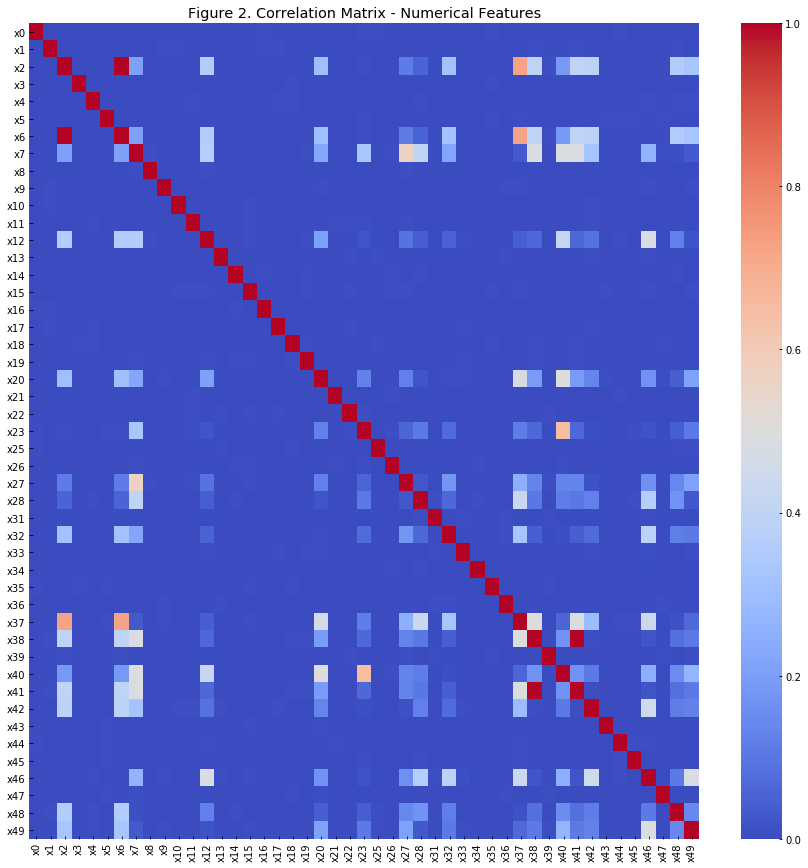

In [127]:
plt.subplots(figsize=(15,15))
ax = sns.heatmap(correlation_matrix, cmap='coolwarm')
ax.set_title('Figure 2. Correlation Matrix - Numerical Features')

In [18]:
s = correlation_matrix.unstack()
so = s.sort_values(kind="quicksort")

so[2157:2163]

x6   x37    0.726485
x2   x6     0.999731
x6   x2     0.999731
x41  x38    0.999755
x38  x41    0.999755
x0   x0     1.000000
dtype: float64

Eliminate the 2 features with the highest correlation (redundant)

In [19]:
high_correlation = ['x6', 'x41']
    
data_float = data_float.drop(data_float[high_correlation], axis = 1)

data_float.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 45 columns):
x0     160000 non-null float32
x1     160000 non-null float32
x2     160000 non-null float32
x3     160000 non-null float32
x4     160000 non-null float32
x5     160000 non-null float32
x7     160000 non-null float32
x8     160000 non-null float32
x9     160000 non-null float32
x10    160000 non-null float32
x11    160000 non-null float32
x12    160000 non-null float32
x13    160000 non-null float32
x14    160000 non-null float32
x15    160000 non-null float32
x16    160000 non-null float32
x17    160000 non-null float32
x18    160000 non-null float32
x19    160000 non-null float32
x20    160000 non-null float32
x21    160000 non-null float32
x22    160000 non-null float32
x23    160000 non-null float32
x25    160000 non-null float32
x26    160000 non-null float32
x27    160000 non-null float32
x28    160000 non-null float32
x31    160000 non-null float32
x32    160000 non-nul

### Standardization and Scaling

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_float.values)

In [21]:
df_scaled = pd.DataFrame(data_scaled, index=data_float.index, columns=data_float.columns)

df_scaled.describe()

,x0,x1,x2,x3,x4,x5,x7,x8,x9,x10,...,x39,x40,x42,x43,x44,x45,x46,x47,x48,x49
count,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,...,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05,1.600000e+05
mean,-1.189709e-08,1.287460e-09,-3.337860e-10,-6.961823e-09,4.863739e-09,-6.675720e-10,7.891655e-09,1.220703e-08,5.912781e-09,-1.883507e-09,...,9.250641e-09,6.914139e-10,-3.240109e-08,2.694130e-09,1.473427e-08,1.621246e-09,-1.287460e-09,-1.027584e-08,6.723404e-09,-1.049042e-08
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-4.288823e+00,-4.144980e+00,-4.388525e+00,-4.396284e+00,-4.460683e+00,-4.412027e+00,-5.691438e+00,-4.231245e+00,-4.404195e+00,-4.613371e+00,...,-4.305838e+00,-4.209860e+00,-5.107345e+00,-4.478940e+00,-4.317236e+00,-4.423038e+00,-5.165183e+00,-4.410353e+00,-4.386877e+00,-4.330972e+00
25%,-6.751329e-01,-6.721856e-01,-6.791493e-01,-6.730526e-01,-6.755947e-01,-6.729232e-01,-6.426278e-01,-6.740778e-01,-6.712440e-01,-6.719363e-01,...,-6.743215e-01,-6.827752e-01,-6.513248e-01,-6.759260e-01,-6.736191e-01,-6.739953e-01,-6.466453e-01,-6.774573e-01,-6.821911e-01,-6.821357e-01
50%,-2.564251e-03,4.255494e-04,-1.404452e-02,-4.649146e-04,6.952658e-05,-8.081700e-09,2.394923e-02,1.320881e-03,-1.789861e-08,-2.218567e-03,...,2.678216e-03,-2.239638e-02,-1.747213e-02,-1.306216e-03,-6.854325e-04,1.657899e-03,-5.963134e-03,1.276095e-03,-5.684652e-03,6.400783e-03
75%,6.724046e-01,6.753187e-01,6.795433e-01,6.781184e-01,6.747798e-01,6.747967e-01,6.518115e-01,6.743743e-01,6.766323e-01,6.768301e-01,...,6.736557e-01,6.627925e-01,6.431129e-01,6.744224e-01,6.696910e-01,6.760232e-01,6.609142e-01,6.763981e-01,6.808351e-01,6.866142e-01
max,4.316499e+00,4.414244e+00,4.874659e+00,4.827667e+00,4.113032e+00,4.633689e+00,5.135741e+00,4.390770e+00,4.307610e+00,4.821049e+00,...,4.195871e+00,5.348155e+00,4.794627e+00,4.354406e+00,4.581107e+00,4.206725e+00,4.469742e+00,4.346286e+00,4.250900e+00,4.492916e+00


Text(0.5, 1.0, 'Figure 3. Individual Histograms of Numerical Features')

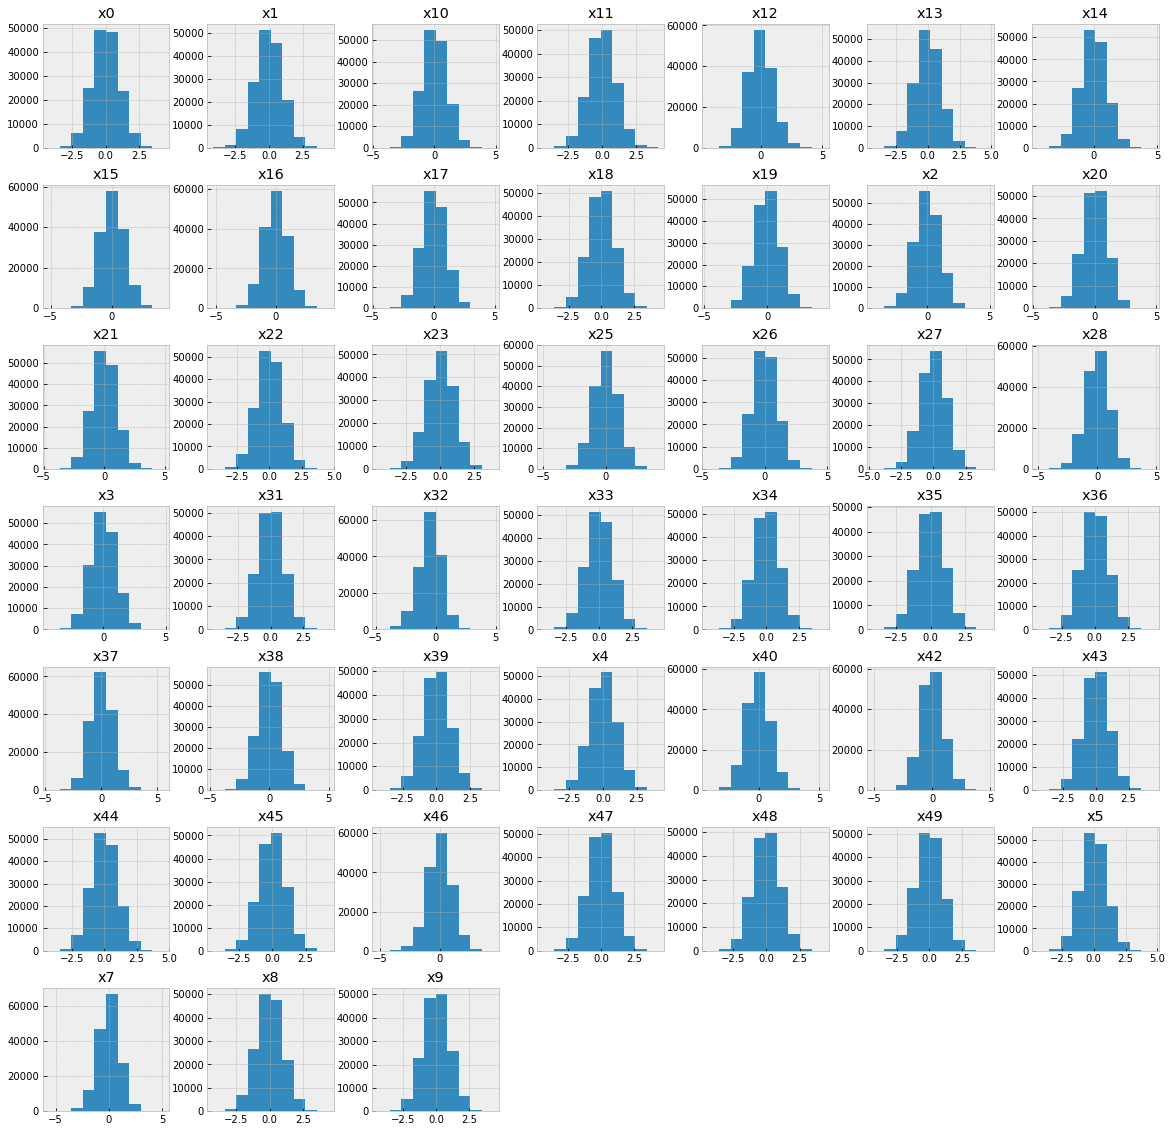

In [128]:
hist = df_scaled.hist(figsize=[20,20])
plt.title('Figure 3. Individual Histograms of Numerical Features')

### Encoding categorical features

In [23]:
data_str = data.select_dtypes(include = ['object'])
data_str.describe()

,x24,x29,x30
count,159972,159970,159970
unique,3,12,5
top,asia,July,wednesday
freq,138965,45569,101535


In [24]:
data_str.isna().sum()

x24    28
x29    30
x30    30
dtype: int64

In [25]:
df_cat = pd.DataFrame()
df_cat['x24'] = pd.Categorical(data['x24'])
df_cat['x24'].cat.categories

Index(['america', 'asia', 'euorpe'], dtype='object')

In [26]:
df_cat['x29'] = pd.Categorical(data['x29'])
df_cat['x29'].cat.categories

Index(['Apr', 'Aug', 'Dev', 'Feb', 'January', 'July', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'sept.'],
      dtype='object')

In [27]:
df_cat['x30'] = pd.Categorical(data['x30'])
df_cat['x30'].cat.categories

Index(['friday', 'monday', 'thurday', 'tuesday', 'wednesday'], dtype='object')

In [28]:
df_cat_unk = pd.DataFrame()
df_cat_unk['x24'] = df_cat['x24'].replace(np.nan, 'unk', regex=True)
df_cat_unk['x29'] = df_cat['x29'].replace(np.nan, 'unk', regex=True)
df_cat_unk['x30'] = df_cat['x30'].replace(np.nan, 'unk', regex=True)

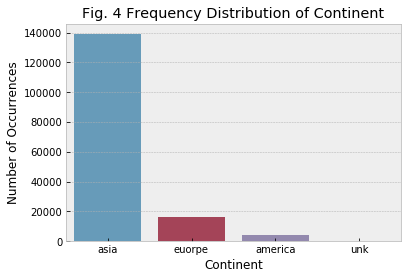

In [129]:
continent_count = df_cat_unk['x24'].value_counts()

sns.barplot(continent_count.index, continent_count.values, alpha = 0.8)
plt.title('Fig. 4 Frequency Distribution of Continent')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Continent', fontsize=12)
plt.show()

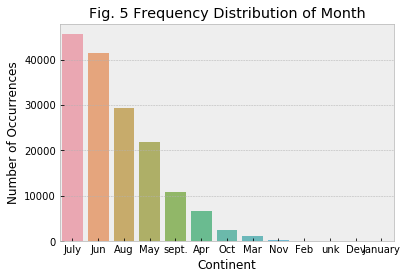

In [130]:
month_count = df_cat_unk['x29'].value_counts()

sns.barplot(month_count.index, month_count.values, alpha = 0.8)
plt.title('Fig. 5 Frequency Distribution of Month')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Continent', fontsize=12)
plt.show()

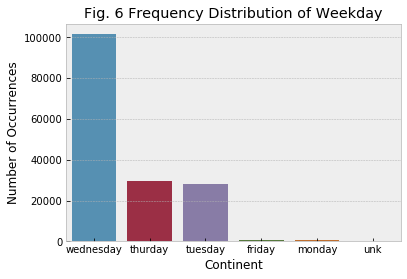

In [131]:
weekday_count = df_cat_unk['x30'].value_counts()

sns.barplot(weekday_count.index, weekday_count.values, alpha = 0.9)
plt.title('Fig. 6 Frequency Distribution of Weekday')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Continent', fontsize=12)
plt.show()

In [32]:
df_cat_unk.head(12)

,x24,x29,x30
0,euorpe,July,tuesday
1,asia,Aug,wednesday
2,asia,July,wednesday
3,asia,July,wednesday
4,asia,July,tuesday
5,asia,Aug,wednesday
6,asia,Jun,wednesday
7,asia,Aug,wednesday
8,asia,May,wednesday
9,asia,Jun,wednesday


In [33]:
columns_to_transform = ['x24', 'x29', 'x30']
data_dummies = pd.get_dummies(df_cat_unk, columns = columns_to_transform)

In [34]:
data_dummies.shape

(160000, 23)

In [35]:
data_dummies.head(12)

,x24_america,x24_asia,x24_euorpe,x24_unk,x29_Apr,x29_Aug,x29_Dev,x29_Feb,x29_January,x29_July,...,x29_Nov,x29_Oct,x29_sept.,x29_unk,x30_friday,x30_monday,x30_thurday,x30_tuesday,x30_unk,x30_wednesday
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
X = pd.concat([df_scaled, data_dummies], axis = 1)
y = data['y']

In [37]:
X.shape

(160000, 68)

In [38]:
y.value_counts()/len(y.index)

0    0.598769
1    0.401231
Name: y, dtype: float64

### Principal Component Analysis

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
x_pca = pca.fit_transform(X)
print (x_pca.shape)
print(pca.explained_variance_ratio_) 
print (pca.explained_variance_ratio_.sum())
loadings = pca.components_

(160000, 45)
[0.0626827  0.0605687  0.03863122 0.03707688 0.03167163 0.02514318
 0.02197896 0.02191497 0.02190097 0.02184216 0.02181623 0.02175907
 0.02175044 0.02174428 0.02165986 0.0216404  0.021629   0.02158931
 0.02155981 0.02151574 0.0214899  0.02146067 0.02144256 0.02141555
 0.0213568  0.02133884 0.02131687 0.02127174 0.02123498 0.0211962
 0.02116898 0.02115899 0.02109857 0.0210814  0.02103531 0.02096283
 0.01930439 0.01779637 0.01632434 0.01394131 0.00740371 0.0058421
 0.00453792 0.00384667 0.00329661]
0.9923990960098256


Text(0.5, 1.0, 'Fig 7. Principal Component Analysis PCA')

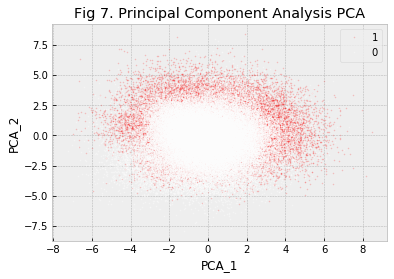

In [132]:
PCA_df = pd.DataFrame()
PCA_df['PCA_1'] = x_pca[:,0]
PCA_df['PCA_2'] = x_pca[:,1]


plt.plot(PCA_df['PCA_1'][data.y == 1], PCA_df['PCA_2'][data.y == 1],'o', alpha = 0.2, color = 'r', markersize = 0.5)
plt.plot(PCA_df['PCA_1'][data.y == 0], PCA_df['PCA_2'][data.y == 0],'o', alpha = 0.4, color = 'w', markersize = 0.5)
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.legend(['1','0'])
plt.title('Fig 7. Principal Component Analysis PCA')

## Model Building

### Train/Test Split

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [42]:
X_train.shape

(128000, 68)

### Random Forest

In [43]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
rf.score(X_test, y_test)

0.92221875

Cross-Validation

In [45]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train, y_train, cv = 5, scoring='accuracy')
print(scores)

[0.91988594 0.91847656 0.91769531 0.91933594 0.91577796]


In [46]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(rf, X_train, y_train, cv = 5)
y_test_pred = cross_val_predict(rf, X_test, y_test, cv = 5)

In [47]:
proba_rf = cross_val_predict(rf, X_train, y_train, cv = 5, method='predict_proba')
proba_rf.shape

(128000, 2)

In [48]:
proba_rf_test = cross_val_predict(rf, X_test, y_test, cv = 5, method='predict_proba')
proba_rf_test.shape

(32000, 2)

Confusion Matrix

In [49]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[73253,  3413],
       [ 7242, 44092]])

In [50]:
c_m_rf = confusion_matrix(y_test, y_test_pred)

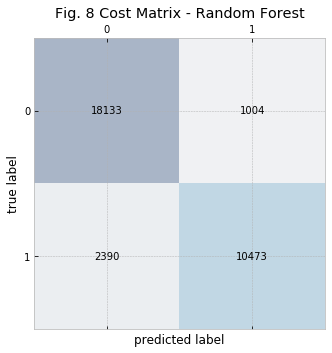

In [134]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(c_m_rf, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(c_m_rf.shape[0]):
    for j in range(c_m_rf.shape[1]):
        ax.text(x = j, y = i, s = c_m_rf[i, j], va = 'center', ha = 'center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Fig. 8 Cost Matrix - Random Forest')
plt.tight_layout()
plt.show()

In [52]:
c_m_rf

array([[18133,  1004],
       [ 2390, 10473]])

In [53]:
cost_matrix = np.array([[0, -1000],[-10, 0]])
total_gain = np.sum(cost_matrix * c_m_rf)
print(cost_matrix * c_m_rf)
print(total_gain)

[[       0 -1004000]
 [  -23900        0]]
-1027900


### Logistic Regression

In [54]:
lr = LogisticRegression(solver='lbfgs', max_iter=500)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
lr_pred = lr.predict(X_test)
lr_pred

array([1, 0, 0, ..., 0, 1, 0])

In [56]:
lr.score(X_test, y_test)

0.7035

In [57]:
lr_scores = cross_val_score(lr, X_train, y_train, cv = 5, scoring='accuracy')
print(lr_scores)

[0.70766767 0.70074219 0.70371094 0.69917969 0.70135552]


In [58]:
y_lr_test_pred = cross_val_predict(lr, X_test, y_test, cv = 5)

In [59]:
proba_lr = cross_val_predict(lr, X_train, y_train, cv = 5, method='predict_proba')
proba_lr.shape

(128000, 2)

In [60]:
proba_lr_test = cross_val_predict(lr, X_test, y_test, cv = 5, method='predict_proba')
proba_lr_test.shape

(32000, 2)

Confusion Matrix

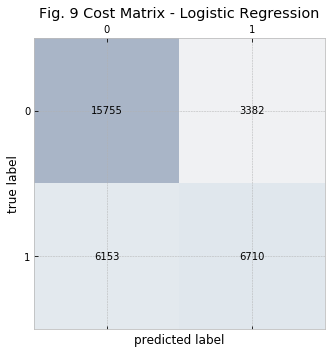

In [135]:
c_m_lr = confusion_matrix(y_test, y_lr_test_pred)

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(c_m_lr, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(c_m_lr.shape[0]):
    for j in range(c_m_lr.shape[1]):
        ax.text(x = j, y = i, s = c_m_lr[i, j], va = 'center', ha = 'center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Fig. 9 Cost Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

In [62]:
c_m_lr

array([[15755,  3382],
       [ 6153,  6710]])

In [63]:
total_gain_lr = np.sum(cost_matrix * c_m_lr)
print(cost_matrix * c_m_lr)
print(total_gain_lr)

[[       0 -3382000]
 [  -61530        0]]
-3443530


### K-Neighbors Classifier

**Warning:** It takes very long time to run)

In [64]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [109]:
kn_pred = lr.predict(X_test)
kn_pred

array([1, 0, 0, ..., 0, 1, 0])

In [110]:
kn.score(X_test, y_test)

0.7940625

In [114]:
kn_scores = cross_val_score(kn, X_train, y_train, cv = 5, scoring='accuracy')
print(kn_scores)

[0.79035975 0.7853125  0.78625    0.785625   0.7849916 ]


In [65]:
y_kn_test_pred = cross_val_predict(kn, X_test, y_test, cv = 5)

In [80]:
proba_kn = cross_val_predict(kn, X_train, y_train, cv = 5, method='predict_proba')
proba_kn.shape

(128000, 2)

In [81]:
proba_kn_test = cross_val_predict(kn, X_test, y_test, cv = 5, method='predict_proba')
proba_kn_test.shape

(32000, 2)

Confusion Matrix

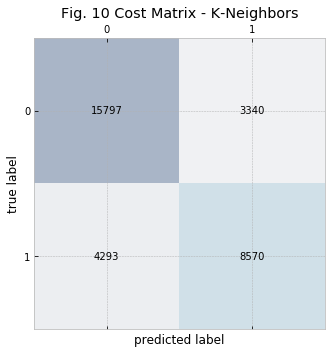

In [136]:
c_m_kn = confusion_matrix(y_test, y_kn_test_pred)

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(c_m_kn, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(c_m_kn.shape[0]):
    for j in range(c_m_kn.shape[1]):
        ax.text(x = j, y = i, s = c_m_kn[i, j], va = 'center', ha = 'center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Fig. 10 Cost Matrix - K-Neighbors')
plt.tight_layout()
plt.show()

In [67]:
c_m_kn

array([[15797,  3340],
       [ 4293,  8570]])

In [68]:
total_gain_kn = np.sum(cost_matrix * c_m_kn)
print(cost_matrix * c_m_kn)
print(total_gain_kn)

[[       0 -3340000]
 [  -42930        0]]
-3382930


### Support Vector Classification

In [70]:
from sklearn.svm import SVC

sv = SVC(gamma='auto', probability = True)
sv.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [122]:
sv_pred = sv.predict(X_test)
sv_pred

array([1, 1, 1, ..., 1, 1, 0])

In [123]:
sv.score(X_test, y_test)

0.8943125

In [124]:
sv_scores = cross_val_score(sv, X_train, y_train, cv = 5, scoring='accuracy')
print(sv_scores)

[0.89383227 0.89007813 0.88785156 0.89132813 0.88866753]


In [71]:
y_sv_test_pred = cross_val_predict(sv, X_test, y_test, cv = 5)

In [72]:
proba_sv = cross_val_predict(sv, X_train, y_train, cv = 5, method='predict_proba')
proba_sv.shape

(128000, 2)

In [73]:
proba_sv_test = cross_val_predict(sv, X_test, y_test, cv = 5, method='predict_proba')
proba_sv_test.shape

(32000, 2)

Confusion Matrix

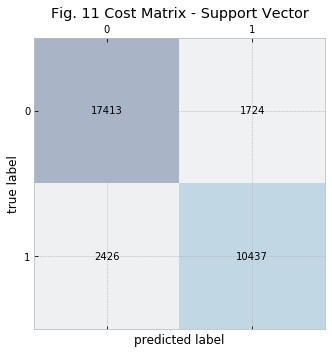

In [137]:
c_m_sv = confusion_matrix(y_test, y_sv_test_pred)

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(c_m_sv, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(c_m_sv.shape[0]):
    for j in range(c_m_sv.shape[1]):
        ax.text(x = j, y = i, s = c_m_sv[i, j], va = 'center', ha = 'center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Fig. 11 Cost Matrix - Support Vector')
plt.tight_layout()
plt.show()

In [75]:
c_m_sv

array([[17413,  1724],
       [ 2426, 10437]])

In [76]:
total_gain_sv = np.sum(cost_matrix * c_m_sv)
print(cost_matrix * c_m_sv)
print(total_gain_sv)

[[       0 -1724000]
 [  -24260        0]]
-1748260


### Neural Networks

In [98]:
import keras

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [101]:
nn = Sequential()
nn.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer='uniform')) # X_train.shape[1] == 28 here
nn.add(Activation('relu'))
nn.add(Dropout(0.10))
nn.add(Dense(100, kernel_initializer='uniform'))
nn.add(Activation('relu'))
nn.add(Dropout(0.10))
nn.add(Dense(1, kernel_initializer='uniform')) 
nn.add(Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [102]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
nn.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [103]:
nn.fit(X_train, y_train, epochs=5, batch_size=1000)
nn_ROC = roc_auc_score(y_test,nn.predict(X_test))
print(nn_ROC)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
128000/128000 [==============================] - 3s 20us/step - loss: 0.5305 - acc: 0.7161
Epoch 2/5
128000/128000 [==============================] - 2s 14us/step - loss: 0.2967 - acc: 0.8774
Epoch 3/5
128000/128000 [==============================] - 2s 14us/step - loss: 0.2501 - acc: 0.8991
Epoch 4/5
128000/128000 [==============================] - 2s 16us/step - loss: 0.2228 - acc: 0.9126
Epoch 5/5
128000/128000 [==============================] - 2s 15us/step - loss: 0.2007 - acc: 0.9230
0.9808461763515992


In [116]:
nn_train = nn.predict(X_train)

In [105]:
nn_pred = nn.predict(X_test)

In [110]:
c_m_nn

array([[17413,  1724],
       [ 2426, 10437]])

In [111]:
total_gain_nn = np.sum(cost_matrix * c_m_nn)
print(cost_matrix * c_m_nn)
print(total_gain_nn)

[[       0 -1724000]
 [  -24260        0]]
-1748260


In [115]:
nn_pred[:, 0]

array([9.6082866e-01, 9.8152047e-01, 9.9918693e-01, ..., 9.8658884e-01,
       9.9510783e-01, 5.9008598e-04], dtype=float32)

## Soft Voting

In [117]:
X_stage2 = pd.DataFrame({'RF_data': proba_rf[:, 1], 'LR_data': proba_lr[:, 1], 
                         'KN_data': proba_kn[:, 1], 'SV_data': proba_sv[:, 1], 
                         'NN_data': nn_train[:, 0]})
X_stage2.tail()

,RF_data,LR_data,KN_data,SV_data,NN_data
127995,0.17,0.547383,0.333333,0.037562,0.013488
127996,0.63,0.476377,0.666667,0.308627,0.585305
127997,0.20,0.269760,0.000000,0.030289,0.006560
127998,0.73,0.238704,0.666667,0.646045,0.955480
127999,0.40,0.717167,0.333333,0.176944,0.112940


In [119]:
X_stage2_test = pd.DataFrame({'RF_data': proba_rf_test[:, 1], 'LR_data': proba_lr_test[:, 1], 
                              'KN_data': proba_kn_test[:, 1], 'SV_data': proba_sv_test[:, 1], 
                              'NN_data': nn_pred[:, 0]})
X_stage2_test.tail()

,RF_data,LR_data,KN_data,SV_data,NN_data
31995,0.07,0.118770,0.000000,0.015361,0.112758
31996,0.22,0.721737,0.000000,0.048981,0.001021
31997,0.85,0.445613,0.333333,0.943320,0.986589
31998,0.93,0.698034,0.333333,0.895682,0.995108
31999,0.09,0.146074,0.000000,0.005331,0.000590


In [120]:
stage2 = LogisticRegression(solver='lbfgs', max_iter=100)

stage2.fit(X_stage2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [121]:
stage2.coef_

array([[ 7.18544714, -1.44027186,  0.22436797, -3.33072344,  7.20586269]])

In [122]:
stage2_pred = stage2.predict(X_stage2_test)

In [123]:
c_m_stage2 = confusion_matrix(y_test, stage2_pred)
c_m_stage2

array([[18272,   865],
       [ 1052, 11811]])

Confusion Matrix

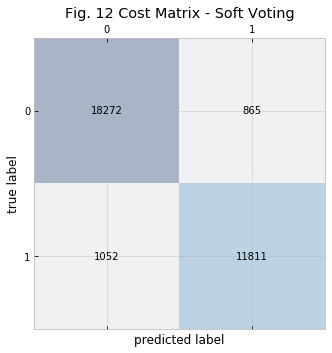

In [138]:
c_m_stage2 = confusion_matrix(y_test, stage2_pred)

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(c_m_stage2, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(c_m_stage2.shape[0]):
    for j in range(c_m_stage2.shape[1]):
        ax.text(x = j, y = i, s = c_m_stage2[i, j], va = 'center', ha = 'center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Fig. 12 Cost Matrix - Soft Voting')
plt.tight_layout()
plt.show()

In [125]:
total_gain_stage2 = np.sum(cost_matrix * c_m_stage2)
print(cost_matrix * c_m_stage2)
print(total_gain_stage2)

[[      0 -865000]
 [ -10520       0]]
-875520


## Hard Voting

In [139]:
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver='lbfgs', max_iter=100)
rnd_clf = RandomForestClassifier(n_estimators = 100)
svm_clf = SVC(gamma='auto')

hv = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
hv.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFores...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [140]:
hv_pred = hv.predict(X_test)

/Users/oscarpadilla/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [141]:
c_m_hv = confusion_matrix(y_test, hv_pred)
c_m_hv

array([[18047,  1090],
       [ 2015, 10848]])

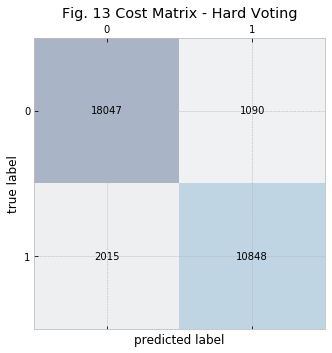

In [144]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(c_m_hv, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(c_m_hv.shape[0]):
    for j in range(c_m_hv.shape[1]):
        ax.text(x = j, y = i, s = c_m_hv[i, j], va = 'center', ha = 'center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Fig. 13 Cost Matrix - Hard Voting')
plt.tight_layout()
plt.show()

In [143]:
total_gain_hv = np.sum(cost_matrix * c_m_hv)
print(cost_matrix * c_m_hv)
print(total_gain_hv)

[[       0 -1090000]
 [  -20150        0]]
-1110150


# Results

Let's summarize all result from all the experiments above in Table 1 below.

| Method        | Total Gain  | Time        |
| ------------- | ----------- | ----------- |
| Random Forest | -1027900    | Super Fast  |
| Logistic Reg  | -3443530    | Fast        |
| K-Neighbors   | -3382930    | Medium      |
| Support Vector| -1748260    | Super Slow  |
| Neural Network|      N/A    | Super Fast  |
| Soft Voting   |  -875520    | Fast        |
| Hard Voting   | -1110150    | Medium      |

Table 1. Summary of Classifier Results in terms of Total Gain and Run Time

* Super Fast < 1 minute
* Fast < 5 minutes
* Medium < 30 minutes
* Super Slow > 1 day!!!

# Conclusion

Obviously the goal of this study is to attain the best model in terms of maximizing the *Total Gain* (or minimizing the cost). 
Given the results in Table 1 above, we conclude that --not surprisingly--as theory suggested, *Soft Voting* yielded the highest gain.

Surprisingly, the *Hard Voting* couldn't beat *Random Forest*.

## Key Takeaways

* Do not run SVC with >100k rows, 50+ features and `probability = True` hyperparameter
* Set timers beforehand so performance can be compared objectively
* Run a smaller sub-dataset first, determine the most important features, perform feature reduction, and then --perhaps-- run SVC

# References

1. Aurélien Géron, *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow*, 2nd Edition, O'Reilly Media

2. Evan Lutins, *Ensemble Methods in Machine Learning: What are They and Why Use Them?*, Towards Data Science, https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f